# Importing Required Libraries

In [1]:
import time
import pickle
import random
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split

# Making Results Reproducible

In [2]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [3]:
device = 'cuda'
# device = 'cpu'

# Reading The Dataset


In [4]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz

import tarfile
with tarfile.open("./cifar-100-python.tar.gz", "r:gz") as tar:
    tar.extractall(path="./")

--2024-05-01 03:43:49--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz.1’

cifar-100-python.ta 100%[===================>] 161.17M  11.7MB/s    in 32s     

2024-05-01 03:44:22 (5.11 MB/s) - ‘cifar-100-python.tar.gz.1’ saved [169001437/169001437]



In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

d1 = unpickle('./cifar-100-python/train')
print(d1.keys())

d2 = unpickle('./cifar-100-python/test')
print(d2.keys())

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


In [6]:
def get_tensor_data(data):
    images = data[b'data']
    labels = data[b'fine_labels']

    N = images.shape[0]
    images = images.reshape((N, 3, 32, 32))
    labels = np.array(labels)

    return torch.tensor(images, dtype=torch.float32) / 255.0, torch.tensor(labels)


In [7]:
data_images, data_labels = get_tensor_data(d1)
test_images, test_labels = get_tensor_data(d2)

# Showing Examples From Datasets For Sanity Checking

In [8]:
def show_example(image, label):
  print("Label :", label.item())
  pyplot.imshow(image.permute((1, 2, 0)))

index = 21695
Label : 82


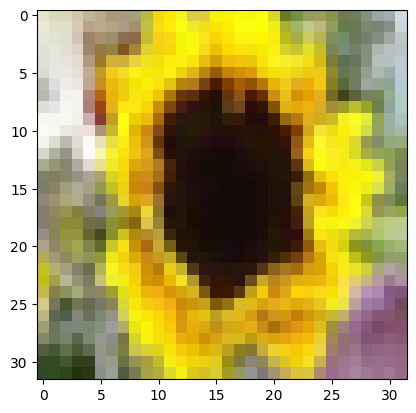

In [9]:
index = random.randint(0, 50000)
print("index =", index)
show_example(data_images[index], data_labels[index])

index = 1237
Label : 23


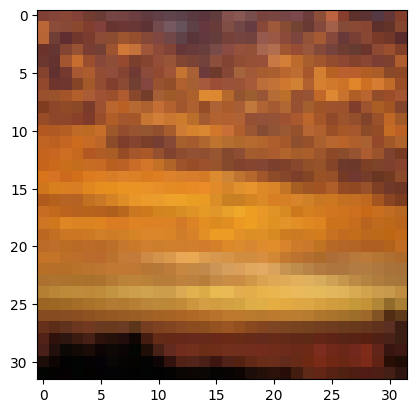

In [10]:
index = random.randint(0, 10000)
print("index =", index)
show_example(test_images[index], test_labels[index])

# Loading The Datset For Training Model

In [11]:
train_examples = 45000
validation_examples = 5000

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.X = images
        self.Y = labels

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.Y[index])


dataset = CustomDataset(data_images, data_labels)
train_set, validation_set = random_split(dataset, [train_examples, validation_examples])
test_set = CustomDataset(test_images, test_labels)

# Defining The Model

In [12]:
class Wide_ResNet(nn.Module):
    def __init__(self, width = 4, dropout = 0.33, num_classes=100):
        super().__init__()

        self.block0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.block11 = nn.Sequential(
            nn.Conv2d(16, 16*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
        )
        self.shortcut1 = nn.Conv2d(16, 16*width, kernel_size=1, stride=2)
        self.block12 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
        )


        self.pre_block2 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
        )
        self.block21 = nn.Sequential(
            nn.Conv2d(16*width, 32*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
        )
        self.shortcut2 = nn.Conv2d(16*width, 32*width, kernel_size=1, stride=2)
        self.block22 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
        )

        self.pre_block3 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
        )
        self.block31 = nn.Sequential(
            nn.Conv2d(32*width, 64*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
        )
        self.shortcut3 = nn.Conv2d(32*width, 64*width, kernel_size=1, stride=2)
        self.block32 = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
        )

        self.pool_block = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.AvgPool2d(4, 4), # Depending on Dataset this should change
        )

        self.fc = nn.Sequential(
            nn.Linear(64*width, 64*width),
            nn.ReLU(),
            nn.Dropout1d(dropout/2),
            nn.Linear(64*width, num_classes)
        )

    def forward(self, x):
        # x.shape = B x 3 x 32 x 32

        x = self.block0(x)
        # x.shape = B x 16 x 32 x 32

        x1 = self.block11(x)
        x2 = self.shortcut1(x)
        x3 = x1 + x2
        x4 = self.block12(x3)
        x = x3 + x4
        # x.shape = B x 16*width x 16 x 16

        x = self.pre_block2(x)
        x1 = self.block21(x)
        x2 = self.shortcut2(x)
        x3 = x1 + x2
        x4 = self.block22(x3)
        x = x3 + x4
        # x.shape = B x 32*width x 8 x 8

        x = self.pre_block3(x)
        x1 = self.block31(x)
        x2 = self.shortcut3(x)
        x3 = x1 + x2
        x4 = self.block32(x3)
        x = x3 + x4
        # x.shape = B x 64*width x 4 x 4

        x = self.pool_block(x)
        # x.shape = B x 64*width x 1 x 1

        x = torch.flatten(x, start_dim=1)
        # flatten all dimensions except batch (0th dim)
        # x.shape = B x 64*width

        x = self.fc(x)
        # x.shape = B x num_classes

        return x


# Helper Functions To Train And Test The Model

In [13]:
def validate(model, validation_loader, loss_fn):
  validation_loss = 0.0
  validation_correct = 0
  model.eval()
  with torch.no_grad(): 
    for j, (x_val, y_val) in enumerate(validation_loader):
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      y_pred = model(x_val)
      loss = loss_fn(y_pred, y_val)

      predicted = torch.argmax(y_pred.data, dim=1)
      validation_correct += (predicted == y_val).sum().item()
      validation_loss += loss.item()

  return validation_loss, validation_correct

In [14]:
def test(model, test_loader):
  top1_correct = 0
  top5_correct = 0
  model.eval()
  with torch.no_grad(): 
    for j, (x_val, y_val) in enumerate(test_loader):
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      y_pred = model(x_val)

      predicted = torch.argmax(y_pred.data, dim=1)
      top1_correct += (predicted == y_val).sum().item()

      val, ind = torch.topk(y_pred.data, 5, dim=1, largest=True, sorted=True)
      for i in range(5):
        top5_correct += (ind[ :, i] == y_val).sum().item()

  return top1_correct / 100, top5_correct / 100

In [15]:
def train(model, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate, num_epochs):
  history = {'train_loss' : [], 'val_loss' : [], 'train_acc' : [], 'val_acc' : [], 'test_acc1' : [], 'test_acc5' : [], 'time' : []}
  optimizer = optimizer(model.parameters(), learning_rate, momentum=0.9, nesterov=True)
  scheduler = scheduler(optimizer, T_max=len(train_loader)*num_epochs)

  for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0
    start = time.time()
    for i, (x_batch, y_batch) in enumerate(train_loader):
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
    
      y_pred = model(x_batch)
      loss = loss_fn(y_pred, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step()

      predicted = torch.argmax(y_pred.data, dim=1)
      train_correct += (predicted == y_batch).sum().item()
      train_loss += loss.item()
    end = time.time()
      
    # Validation Step
    validation_loss, validation_correct = validate(model, validation_loader, loss_fn)

    print("Epoch", epoch+1, "-\tTraining Loss :", train_loss/train_examples, "\tValidation Loss :", validation_loss/validation_examples)
    history['train_loss'].append(train_loss / train_examples)
    history['val_loss'].append(validation_loss / validation_examples)
    history['train_acc'].append(100 * train_correct / train_examples)
    history['val_acc'].append(100 * validation_correct / validation_examples)
    history['time'].append(end - start)

    # Test Step every 5th epoch
    if (epoch % 5) == 4:
      top1, top5 = test(model, test_loader)
      history['test_acc1'].append(top1)
      history['test_acc5'].append(top5)

      print("Training Accuracy =", 100 * train_correct / train_examples,
            "\tValidation Accuracy =", 100 * validation_correct / validation_examples,
            "\tTest Accuracy Top1 =", top1, "\tTest Accuracy Top5 =", top5)

  return history

In [16]:
def plot_loss(train_loss, val_loss):
  pyplot.plot(train_loss, '-b')
  pyplot.plot(val_loss, '-r')
  pyplot.xlabel('epoch')
  pyplot.ylabel('loss')
  pyplot.legend(['Training', 'Validation'])
  pyplot.title('Loss vs. No. of epochs')

In [17]:
def plot_acc(train_acc, val_acc):
  pyplot.plot(train_acc, '-b')
  pyplot.plot(val_acc, '-r')
  pyplot.xlabel('epoch')
  pyplot.ylabel('acurracy')
  pyplot.legend(['Training', 'Validation'])
  pyplot.title('Acurracy vs. No. of epochs')

In [18]:
def plot_test(test_acc1, test_acc5):
  x = range(5, 201, 5)
  x = x[ : len(test_acc1)]
  pyplot.plot(x, test_acc1, '-b')
  pyplot.plot(x, test_acc5, '-r')
  pyplot.xlabel('epoch')
  pyplot.ylabel('accuracy')
  pyplot.legend(['Top1 Accuracy', 'Top5 Accuracy'])
  pyplot.title('Accuracy vs. No. of epochs')

# Training The Model

In [19]:
model1 = Wide_ResNet(width=8, dropout=0.5).to(device)
summary(model1, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]          18,560
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
            Conv2d-9          [-1, 128, 16, 16]           2,176
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [20]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

optimizer = torch.optim.SGD
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
loss_fn = F.cross_entropy

history1 = train(model1, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=100)

/data/home1/shishirm/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  1%|          | 1/100 [00:09<16:15,  9.85s/it]

Epoch 1 -	Training Loss : 0.03456027432547675 	Validation Loss : 0.016843303108215333


  2%|▏         | 2/100 [00:18<14:50,  9.09s/it]

Epoch 2 -	Training Loss : 0.031768147039413455 	Validation Loss : 0.014978043603897095


  3%|▎         | 3/100 [00:27<14:24,  8.91s/it]

Epoch 3 -	Training Loss : 0.030673151344723173 	Validation Loss : 0.015291814470291138


  4%|▍         | 4/100 [00:35<13:57,  8.72s/it]

Epoch 4 -	Training Loss : 0.029702393854988945 	Validation Loss : 0.013750119256973267
Epoch 5 -	Training Loss : 0.028726562166213988 	Validation Loss : 0.013379308080673218


  5%|▌         | 5/100 [00:44<14:08,  8.93s/it]

Training Accuracy = 13.786666666666667 	Validation Accuracy = 19.82 	Test Accuracy Top1 = 19.45 	Test Accuracy Top5 = 47.81


  6%|▌         | 6/100 [00:53<14:02,  8.97s/it]

Epoch 6 -	Training Loss : 0.027905552032258776 	Validation Loss : 0.013328553724288941


  7%|▋         | 7/100 [01:02<13:46,  8.89s/it]

Epoch 7 -	Training Loss : 0.027171179474724663 	Validation Loss : 0.012238099002838135


  8%|▊         | 8/100 [01:11<13:27,  8.77s/it]

Epoch 8 -	Training Loss : 0.026462882407506307 	Validation Loss : 0.011609349727630615


  9%|▉         | 9/100 [01:19<13:11,  8.69s/it]

Epoch 9 -	Training Loss : 0.025882777759763928 	Validation Loss : 0.011778426170349122
Epoch 10 -	Training Loss : 0.025373433054818047 	Validation Loss : 0.010940859222412109


 10%|█         | 10/100 [01:28<13:15,  8.84s/it]

Training Accuracy = 21.746666666666666 	Validation Accuracy = 32.28 	Test Accuracy Top1 = 32.33 	Test Accuracy Top5 = 63.57


 11%|█         | 11/100 [01:37<13:02,  8.79s/it]

Epoch 11 -	Training Loss : 0.024794838004642064 	Validation Loss : 0.010595381212234497


 12%|█▏        | 12/100 [01:46<12:50,  8.75s/it]

Epoch 12 -	Training Loss : 0.024246033154593574 	Validation Loss : 0.010429138422012329


 13%|█▎        | 13/100 [01:54<12:41,  8.76s/it]

Epoch 13 -	Training Loss : 0.023756717777252197 	Validation Loss : 0.010133676195144653


 14%|█▍        | 14/100 [02:03<12:31,  8.74s/it]

Epoch 14 -	Training Loss : 0.023214847305085926 	Validation Loss : 0.00978655400276184
Epoch 15 -	Training Loss : 0.022701960701412626 	Validation Loss : 0.009617375135421753


 15%|█▌        | 15/100 [02:12<12:27,  8.80s/it]

Training Accuracy = 28.788888888888888 	Validation Accuracy = 38.12 	Test Accuracy Top1 = 39.42 	Test Accuracy Top5 = 70.96


 16%|█▌        | 16/100 [02:21<12:16,  8.76s/it]

Epoch 16 -	Training Loss : 0.022352337058385213 	Validation Loss : 0.009159837818145751


 17%|█▋        | 17/100 [02:29<11:55,  8.62s/it]

Epoch 17 -	Training Loss : 0.021836526934305826 	Validation Loss : 0.009328337860107422


 18%|█▊        | 18/100 [02:38<12:01,  8.80s/it]

Epoch 18 -	Training Loss : 0.021520364353391858 	Validation Loss : 0.008748992681503295


 19%|█▉        | 19/100 [02:47<11:48,  8.75s/it]

Epoch 19 -	Training Loss : 0.021077437655131023 	Validation Loss : 0.008603920936584472
Epoch 20 -	Training Loss : 0.020708502091301813 	Validation Loss : 0.00833602728843689


 20%|██        | 20/100 [02:56<11:48,  8.86s/it]

Training Accuracy = 34.19777777777778 	Validation Accuracy = 44.94 	Test Accuracy Top1 = 46.63 	Test Accuracy Top5 = 77.03


 21%|██        | 21/100 [03:05<11:42,  8.89s/it]

Epoch 21 -	Training Loss : 0.020453801663716634 	Validation Loss : 0.00883179087638855


 22%|██▏       | 22/100 [03:14<11:36,  8.93s/it]

Epoch 22 -	Training Loss : 0.020083868243959215 	Validation Loss : 0.007992363905906677


 23%|██▎       | 23/100 [03:22<11:15,  8.77s/it]

Epoch 23 -	Training Loss : 0.019857636366950142 	Validation Loss : 0.00787659752368927


 24%|██▍       | 24/100 [03:31<11:00,  8.69s/it]

Epoch 24 -	Training Loss : 0.019534504911634658 	Validation Loss : 0.007972723960876464
Epoch 25 -	Training Loss : 0.019210455253389148 	Validation Loss : 0.00777129225730896


 25%|██▌       | 25/100 [03:40<11:05,  8.87s/it]

Training Accuracy = 38.87555555555556 	Validation Accuracy = 48.18 	Test Accuracy Top1 = 49.09 	Test Accuracy Top5 = 79.02


 26%|██▌       | 26/100 [03:49<10:46,  8.74s/it]

Epoch 26 -	Training Loss : 0.018954907083511354 	Validation Loss : 0.00764407913684845


 27%|██▋       | 27/100 [03:57<10:29,  8.62s/it]

Epoch 27 -	Training Loss : 0.018672629613346522 	Validation Loss : 0.007354940867424011


 28%|██▊       | 28/100 [04:06<10:23,  8.66s/it]

Epoch 28 -	Training Loss : 0.018414810143576727 	Validation Loss : 0.007293650555610657


 29%|██▉       | 29/100 [04:14<10:14,  8.65s/it]

Epoch 29 -	Training Loss : 0.018045377445220948 	Validation Loss : 0.007265148591995239
Epoch 30 -	Training Loss : 0.017772018716070388 	Validation Loss : 0.007316046118736267


 30%|███       | 30/100 [04:23<10:15,  8.79s/it]

Training Accuracy = 42.93333333333333 	Validation Accuracy = 50.52 	Test Accuracy Top1 = 50.88 	Test Accuracy Top5 = 80.55


 31%|███       | 31/100 [04:32<10:00,  8.70s/it]

Epoch 31 -	Training Loss : 0.017572801785998873 	Validation Loss : 0.007111450672149658


 32%|███▏      | 32/100 [04:41<09:49,  8.66s/it]

Epoch 32 -	Training Loss : 0.017285513835483126 	Validation Loss : 0.00706774570941925


 33%|███▎      | 33/100 [04:50<09:48,  8.78s/it]

Epoch 33 -	Training Loss : 0.017128212830755447 	Validation Loss : 0.007050422358512878


 34%|███▍      | 34/100 [04:58<09:35,  8.71s/it]

Epoch 34 -	Training Loss : 0.016867790383762783 	Validation Loss : 0.006999286437034607
Epoch 35 -	Training Loss : 0.016601596604453192 	Validation Loss : 0.0069075369834899905


 35%|███▌      | 35/100 [05:07<09:36,  8.87s/it]

Training Accuracy = 46.81333333333333 	Validation Accuracy = 51.86 	Test Accuracy Top1 = 53.09 	Test Accuracy Top5 = 82.28


 36%|███▌      | 36/100 [05:16<09:21,  8.77s/it]

Epoch 36 -	Training Loss : 0.016436502742767332 	Validation Loss : 0.0068064073324203495


 37%|███▋      | 37/100 [05:25<09:13,  8.78s/it]

Epoch 37 -	Training Loss : 0.016198189544677735 	Validation Loss : 0.006792901039123535


 38%|███▊      | 38/100 [05:34<09:12,  8.92s/it]

Epoch 38 -	Training Loss : 0.015966518619325427 	Validation Loss : 0.006701587724685669


 39%|███▉      | 39/100 [05:43<08:58,  8.83s/it]

Epoch 39 -	Training Loss : 0.015770443158679537 	Validation Loss : 0.006745765399932861
Epoch 40 -	Training Loss : 0.015491714734501309 	Validation Loss : 0.006728609585762024


 40%|████      | 40/100 [05:52<08:59,  8.98s/it]

Training Accuracy = 50.54222222222222 	Validation Accuracy = 53.24 	Test Accuracy Top1 = 54.67 	Test Accuracy Top5 = 82.74


 41%|████      | 41/100 [06:00<08:42,  8.86s/it]

Epoch 41 -	Training Loss : 0.015307951434453328 	Validation Loss : 0.006689900183677673


 42%|████▏     | 42/100 [06:09<08:30,  8.79s/it]

Epoch 42 -	Training Loss : 0.015080364031261869 	Validation Loss : 0.006656569337844849


 43%|████▎     | 43/100 [06:18<08:14,  8.67s/it]

Epoch 43 -	Training Loss : 0.014907479622628953 	Validation Loss : 0.006711200618743897


 44%|████▍     | 44/100 [06:26<08:06,  8.69s/it]

Epoch 44 -	Training Loss : 0.01480672366089291 	Validation Loss : 0.006574134373664856
Epoch 45 -	Training Loss : 0.014624280529552036 	Validation Loss : 0.006730440974235535


 45%|████▌     | 45/100 [06:35<08:04,  8.82s/it]

Training Accuracy = 53.50222222222222 	Validation Accuracy = 54.38 	Test Accuracy Top1 = 54.59 	Test Accuracy Top5 = 83.09


 46%|████▌     | 46/100 [06:44<07:53,  8.78s/it]

Epoch 46 -	Training Loss : 0.014333152850468954 	Validation Loss : 0.0066155237197875975


 47%|████▋     | 47/100 [06:53<07:45,  8.78s/it]

Epoch 47 -	Training Loss : 0.014115480581919353 	Validation Loss : 0.00655692024230957


 48%|████▊     | 48/100 [07:01<07:33,  8.73s/it]

Epoch 48 -	Training Loss : 0.013952296177546184 	Validation Loss : 0.006682338428497314


 49%|████▉     | 49/100 [07:10<07:26,  8.76s/it]

Epoch 49 -	Training Loss : 0.013631671545240615 	Validation Loss : 0.006541796875
Epoch 50 -	Training Loss : 0.013620239853858948 	Validation Loss : 0.006747602844238281


 50%|█████     | 50/100 [07:20<07:26,  8.94s/it]

Training Accuracy = 57.02 	Validation Accuracy = 54.1 	Test Accuracy Top1 = 55.23 	Test Accuracy Top5 = 82.73


 51%|█████     | 51/100 [07:28<07:13,  8.85s/it]

Epoch 51 -	Training Loss : 0.013382740060488382 	Validation Loss : 0.00664011390209198


 52%|█████▏    | 52/100 [07:37<07:05,  8.86s/it]

Epoch 52 -	Training Loss : 0.013216801993052165 	Validation Loss : 0.006582433414459229


 53%|█████▎    | 53/100 [07:45<06:49,  8.70s/it]

Epoch 53 -	Training Loss : 0.013029568706618415 	Validation Loss : 0.006617962312698364


 54%|█████▍    | 54/100 [07:55<06:45,  8.81s/it]

Epoch 54 -	Training Loss : 0.012832071704334683 	Validation Loss : 0.0068656452417373654
Epoch 55 -	Training Loss : 0.01282590721713172 	Validation Loss : 0.0066181787967681885


 55%|█████▌    | 55/100 [08:04<06:40,  8.90s/it]

Training Accuracy = 60.04888888888889 	Validation Accuracy = 54.96 	Test Accuracy Top1 = 56.67 	Test Accuracy Top5 = 83.98


 56%|█████▌    | 56/100 [08:12<06:30,  8.88s/it]

Epoch 56 -	Training Loss : 0.012627996296352811 	Validation Loss : 0.006619080829620361


 57%|█████▋    | 57/100 [08:21<06:23,  8.91s/it]

Epoch 57 -	Training Loss : 0.012366343381669786 	Validation Loss : 0.006765829586982727


 58%|█████▊    | 58/100 [08:30<06:09,  8.79s/it]

Epoch 58 -	Training Loss : 0.012411505664719475 	Validation Loss : 0.006675561547279358


 59%|█████▉    | 59/100 [08:39<06:05,  8.92s/it]

Epoch 59 -	Training Loss : 0.012272388376129997 	Validation Loss : 0.006690024137496948
Epoch 60 -	Training Loss : 0.012073325408829582 	Validation Loss : 0.006637555694580078


 60%|██████    | 60/100 [08:49<06:03,  9.08s/it]

Training Accuracy = 62.63111111111111 	Validation Accuracy = 55.36 	Test Accuracy Top1 = 56.66 	Test Accuracy Top5 = 84.2


 61%|██████    | 61/100 [08:57<05:49,  8.97s/it]

Epoch 61 -	Training Loss : 0.011858511307504442 	Validation Loss : 0.006807130146026612


 62%|██████▏   | 62/100 [09:06<05:41,  8.97s/it]

Epoch 62 -	Training Loss : 0.01175481776661343 	Validation Loss : 0.0071471138000488285


 63%|██████▎   | 63/100 [09:15<05:27,  8.86s/it]

Epoch 63 -	Training Loss : 0.011555386413468255 	Validation Loss : 0.00683349814414978


 64%|██████▍   | 64/100 [09:24<05:17,  8.81s/it]

Epoch 64 -	Training Loss : 0.011508827386962043 	Validation Loss : 0.006765287446975708
Epoch 65 -	Training Loss : 0.011417128205299377 	Validation Loss : 0.006852140855789185


 65%|██████▌   | 65/100 [09:33<05:14,  8.99s/it]

Training Accuracy = 65.53333333333333 	Validation Accuracy = 56.1 	Test Accuracy Top1 = 56.63 	Test Accuracy Top5 = 84.0


 66%|██████▌   | 66/100 [09:42<05:06,  9.01s/it]

Epoch 66 -	Training Loss : 0.011286525438891517 	Validation Loss : 0.006806664252281189


 67%|██████▋   | 67/100 [09:51<04:52,  8.87s/it]

Epoch 67 -	Training Loss : 0.011318898055288526 	Validation Loss : 0.006860155487060547


 68%|██████▊   | 68/100 [09:59<04:40,  8.78s/it]

Epoch 68 -	Training Loss : 0.011193823907110427 	Validation Loss : 0.0068181261301040645


 69%|██████▉   | 69/100 [10:08<04:28,  8.67s/it]

Epoch 69 -	Training Loss : 0.011066522714826795 	Validation Loss : 0.0069140089511871335
Epoch 70 -	Training Loss : 0.010999699354171753 	Validation Loss : 0.006921714663505554


 70%|███████   | 70/100 [10:17<04:28,  8.96s/it]

Training Accuracy = 67.11777777777777 	Validation Accuracy = 56.18 	Test Accuracy Top1 = 57.27 	Test Accuracy Top5 = 84.44


 71%|███████   | 71/100 [10:26<04:19,  8.93s/it]

Epoch 71 -	Training Loss : 0.010990646033816867 	Validation Loss : 0.00694697265625


 72%|███████▏  | 72/100 [10:35<04:07,  8.85s/it]

Epoch 72 -	Training Loss : 0.01095047257343928 	Validation Loss : 0.007055692911148072


 73%|███████▎  | 73/100 [10:44<04:00,  8.92s/it]

Epoch 73 -	Training Loss : 0.010769962424702115 	Validation Loss : 0.00697231092453003


 74%|███████▍  | 74/100 [10:53<03:53,  9.00s/it]

Epoch 74 -	Training Loss : 0.010754052163494957 	Validation Loss : 0.007076309680938721
Epoch 75 -	Training Loss : 0.010732313210434384 	Validation Loss : 0.007008878397941589


 75%|███████▌  | 75/100 [11:02<03:48,  9.13s/it]

Training Accuracy = 68.30888888888889 	Validation Accuracy = 56.44 	Test Accuracy Top1 = 57.18 	Test Accuracy Top5 = 84.08


 76%|███████▌  | 76/100 [11:11<03:36,  9.03s/it]

Epoch 76 -	Training Loss : 0.010640701194604238 	Validation Loss : 0.007011223936080933


 77%|███████▋  | 77/100 [11:20<03:26,  8.99s/it]

Epoch 77 -	Training Loss : 0.010508677821689181 	Validation Loss : 0.0070923103809356685


 78%|███████▊  | 78/100 [11:29<03:18,  9.02s/it]

Epoch 78 -	Training Loss : 0.010440916454792023 	Validation Loss : 0.007024187922477722


 79%|███████▉  | 79/100 [11:38<03:09,  9.05s/it]

Epoch 79 -	Training Loss : 0.010395395763715108 	Validation Loss : 0.007110256600379944
Epoch 80 -	Training Loss : 0.010424689531326295 	Validation Loss : 0.007054091715812683


 80%|████████  | 80/100 [11:48<03:04,  9.21s/it]

Training Accuracy = 69.65555555555555 	Validation Accuracy = 56.98 	Test Accuracy Top1 = 57.09 	Test Accuracy Top5 = 84.33


 81%|████████  | 81/100 [11:57<02:54,  9.19s/it]

Epoch 81 -	Training Loss : 0.010388616801632776 	Validation Loss : 0.00715004506111145


 82%|████████▏ | 82/100 [12:06<02:42,  9.02s/it]

Epoch 82 -	Training Loss : 0.010396252920892503 	Validation Loss : 0.007114406108856201


 83%|████████▎ | 83/100 [12:15<02:32,  8.98s/it]

Epoch 83 -	Training Loss : 0.010324592447280883 	Validation Loss : 0.007099474287033081


 84%|████████▍ | 84/100 [12:23<02:22,  8.90s/it]

Epoch 84 -	Training Loss : 0.01028247468471527 	Validation Loss : 0.007118395066261291
Epoch 85 -	Training Loss : 0.010339796078205109 	Validation Loss : 0.00711748628616333


 85%|████████▌ | 85/100 [12:33<02:16,  9.11s/it]

Training Accuracy = 70.14888888888889 	Validation Accuracy = 56.7 	Test Accuracy Top1 = 57.18 	Test Accuracy Top5 = 84.31


 86%|████████▌ | 86/100 [12:42<02:07,  9.12s/it]

Epoch 86 -	Training Loss : 0.01031855742401547 	Validation Loss : 0.007179777264595032


 87%|████████▋ | 87/100 [12:51<01:56,  8.97s/it]

Epoch 87 -	Training Loss : 0.010342022323608398 	Validation Loss : 0.007162713408470154


 88%|████████▊ | 88/100 [12:59<01:46,  8.89s/it]

Epoch 88 -	Training Loss : 0.01026816166109509 	Validation Loss : 0.007137753081321716


 89%|████████▉ | 89/100 [13:08<01:38,  8.93s/it]

Epoch 89 -	Training Loss : 0.01020047246085273 	Validation Loss : 0.007159797477722168
Epoch 90 -	Training Loss : 0.010265193671650357 	Validation Loss : 0.007157155013084411


 90%|█████████ | 90/100 [13:18<01:31,  9.12s/it]

Training Accuracy = 70.50666666666666 	Validation Accuracy = 56.54 	Test Accuracy Top1 = 57.19 	Test Accuracy Top5 = 84.37


 91%|█████████ | 91/100 [13:27<01:21,  9.04s/it]

Epoch 91 -	Training Loss : 0.010176353475782607 	Validation Loss : 0.007166603779792786


 92%|█████████▏| 92/100 [13:36<01:11,  8.97s/it]

Epoch 92 -	Training Loss : 0.01024870181745953 	Validation Loss : 0.007153845596313477


 93%|█████████▎| 93/100 [13:45<01:02,  8.99s/it]

Epoch 93 -	Training Loss : 0.010173873303996193 	Validation Loss : 0.007155154967308045


 94%|█████████▍| 94/100 [13:54<00:53,  8.98s/it]

Epoch 94 -	Training Loss : 0.010264455087979634 	Validation Loss : 0.007156154346466065
Epoch 95 -	Training Loss : 0.010214797192149691 	Validation Loss : 0.007132556223869324


 95%|█████████▌| 95/100 [14:03<00:45,  9.15s/it]

Training Accuracy = 70.67555555555556 	Validation Accuracy = 56.62 	Test Accuracy Top1 = 57.36 	Test Accuracy Top5 = 84.27


 96%|█████████▌| 96/100 [14:12<00:35,  9.00s/it]

Epoch 96 -	Training Loss : 0.010219530194335514 	Validation Loss : 0.007152039861679077


 97%|█████████▋| 97/100 [14:20<00:26,  8.86s/it]

Epoch 97 -	Training Loss : 0.01030799469947815 	Validation Loss : 0.007156276106834412


 98%|█████████▊| 98/100 [14:29<00:17,  8.92s/it]

Epoch 98 -	Training Loss : 0.01027849151690801 	Validation Loss : 0.007168533110618591


 99%|█████████▉| 99/100 [14:38<00:08,  8.95s/it]

Epoch 99 -	Training Loss : 0.010167611988385518 	Validation Loss : 0.007130177879333496
Epoch 100 -	Training Loss : 0.010064826042122312 	Validation Loss : 0.007164909768104554


100%|██████████| 100/100 [14:48<00:00,  8.88s/it]

Training Accuracy = 71.12 	Validation Accuracy = 56.66 	Test Accuracy Top1 = 57.11 	Test Accuracy Top5 = 84.33


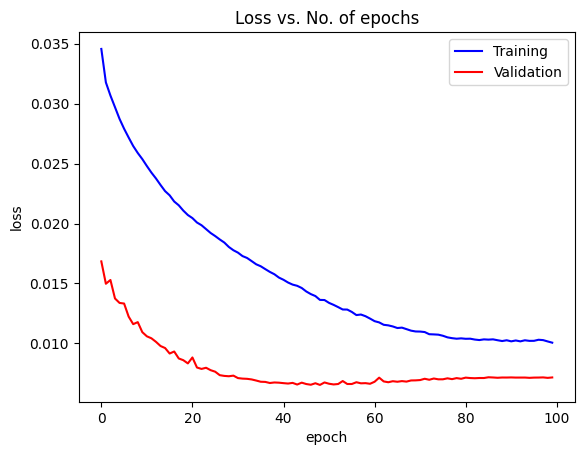

In [21]:
plot_loss(history1['train_loss'], history1['val_loss'])

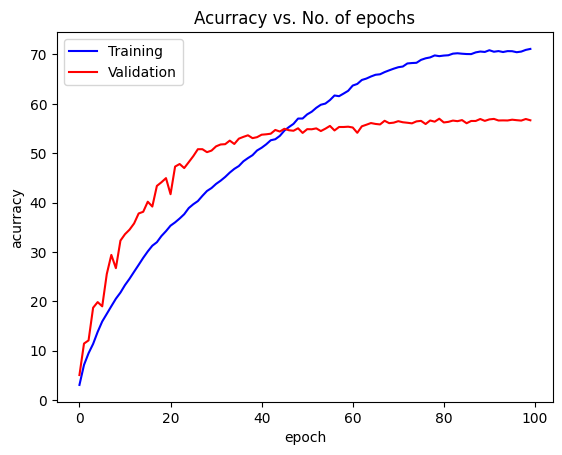

In [22]:
plot_acc(history1['train_acc'], history1['val_acc'])

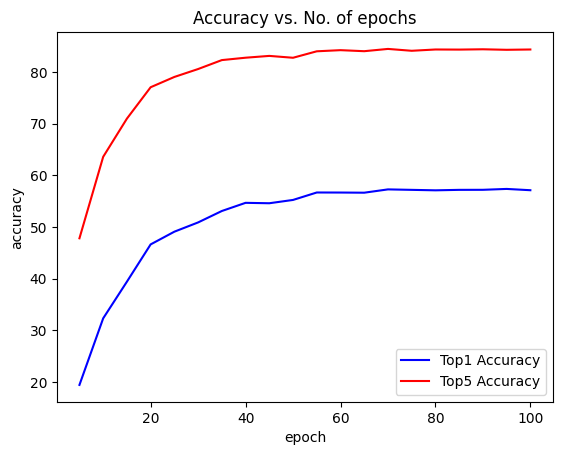

In [23]:
plot_test(history1['test_acc1'], history1['test_acc5'])

In [24]:
time_taken1 = np.array(history1['time'])
print("Average time per epoch for Wide_ResNet =", np.mean(time_taken1))

Average time per epoch for Wide_ResNet = 8.422302322387695


In [25]:
with open('wide_resnet_history_cifar', 'wb') as f:
  pickle.dump(history1, f)

# Defining The Model

In [26]:
from AA_CNN import AttentionConv2d

In [27]:
class Wide_AAResNet(nn.Module):
    def __init__(self, width = 4, dropout = 0.33, num_classes=100):
        super().__init__()
        self.Nh = 1
        self.dv = 8

        self.block0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.block11 = nn.Sequential(
            nn.Conv2d(16, 16*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 16*width,
                output_dim = 16*width,
                dk = 4*self.dv*width,
                dv = self.dv*width,
                num_heads = self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=16,
                width=16,
            ),
        )
        self.shortcut1 = nn.Conv2d(16, 16*width, kernel_size=1, stride=2)
        self.block12 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 16*width,
                output_dim = 16*width,
                dk = 4*self.dv*width,
                dv = self.dv*width,
                num_heads = self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=16,
                width=16,
            ),
        )


        self.pre_block2 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
        )
        self.block21 = nn.Sequential(
            nn.Conv2d(16*width, 32*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 32*width,
                output_dim = 32*width,
                dk = 8*self.dv*width,
                dv = 2*self.dv*width,
                num_heads = 2*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=8,
                width=8,
            ),
        )
        self.shortcut2 = nn.Conv2d(16*width, 32*width, kernel_size=1, stride=2)
        self.block22 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 32*width,
                output_dim = 32*width,
                dk = 8*self.dv*width,
                dv = 2*self.dv*width,
                num_heads = 2*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=8,
                width=8,
            ),
        )

        self.pre_block3 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
        )
        self.block31 = nn.Sequential(
            nn.Conv2d(32*width, 64*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 64*width,
                output_dim = 64*width,
                dk = 16*self.dv*width,
                dv = 4*self.dv*width,
                num_heads = 4*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=4,
                width=4,
            ),
        )
        self.shortcut3 = nn.Conv2d(32*width, 64*width, kernel_size=1, stride=2)
        self.block32 = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 64*width,
                output_dim = 64*width,
                dk = 16*self.dv*width,
                dv = 4*self.dv*width,
                num_heads = 4*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=4,
                width=4,
            ),
        )

        self.pool_block = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.AvgPool2d(4, 4),
        )

        self.fc = nn.Sequential(
            nn.Linear(64*width, 64*width),
            nn.ReLU(),
            nn.Dropout1d(dropout/2),
            nn.Linear(64*width, num_classes)
        )

    def forward(self, x):
        # x.shape = B x 3 x 32 x 32

        x = self.block0(x)
        # x.shape = B x 16 x 32 x 32

        x1 = self.block11(x)
        x2 = self.shortcut1(x)
        x3 = x1 + x2
        x4 = self.block12(x3)
        x = x4 + x3
        # x.shape = B x 16*width x 16 x 16

        x = self.pre_block2(x)
        x1 = self.block21(x)
        x2 = self.shortcut2(x)
        x3 = x1 + x2
        x4 = self.block22(x3)
        x = x4 + x3
        # x.shape = B x 32*width x 8 x 8

        x = self.pre_block3(x)
        x1 = self.block31(x)
        x2 = self.shortcut3(x)
        x3 = x1 + x2
        x4 = self.block32(x3)
        x = x4 + x3
        # x.shape = B x 64*width x 4 x 4

        x = self.pool_block(x)
        # x.shape = B x 64*width x 1 x 1

        x = torch.flatten(x, start_dim=1)
        # flatten all dimensions except batch (0th dim)
        # x.shape = B x 64*width

        x = self.fc(x)
        # x.shape = B x num_classes

        return x

# Training The Model

In [28]:
model2 = Wide_AAResNet(width=8, dropout=0.5).to(device)
summary(model2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]          18,560
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          73,792
            Conv2d-9          [-1, 576, 16, 16]          74,304
          Softmax-10          [-1, 1, 256, 256]               0
           Conv2d-11           [-1, 64, 16, 16]           4,160
  AttentionConv2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]           2,176
      BatchNorm2d-14          [-1, 128,

In [29]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

optimizer = torch.optim.SGD
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
loss_fn = F.cross_entropy

history2 = train(model2, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=100)

  1%|          | 1/100 [00:13<22:32, 13.66s/it]

Epoch 1 -	Training Loss : 0.034119411616855194 	Validation Loss : 0.01596509199142456


  2%|▏         | 2/100 [00:27<22:35, 13.83s/it]

Epoch 2 -	Training Loss : 0.031413429647021825 	Validation Loss : 0.01483521614074707


  3%|▎         | 3/100 [00:41<22:02, 13.63s/it]

Epoch 3 -	Training Loss : 0.030131653436024985 	Validation Loss : 0.014036386394500732


  4%|▍         | 4/100 [00:54<21:38, 13.53s/it]

Epoch 4 -	Training Loss : 0.028996963760587906 	Validation Loss : 0.013464451837539674
Epoch 5 -	Training Loss : 0.027746480406655206 	Validation Loss : 0.012881092023849487


  5%|▌         | 5/100 [01:08<21:58, 13.88s/it]

Training Accuracy = 15.984444444444444 	Validation Accuracy = 21.08 	Test Accuracy Top1 = 20.43 	Test Accuracy Top5 = 50.96


  6%|▌         | 6/100 [01:22<21:30, 13.73s/it]

Epoch 6 -	Training Loss : 0.026767486577563816 	Validation Loss : 0.012419906377792358


  7%|▋         | 7/100 [01:35<21:08, 13.64s/it]

Epoch 7 -	Training Loss : 0.025871860949198404 	Validation Loss : 0.011337383127212525


  8%|▊         | 8/100 [01:49<20:46, 13.55s/it]

Epoch 8 -	Training Loss : 0.02503532674577501 	Validation Loss : 0.011933043003082275


  9%|▉         | 9/100 [02:02<20:41, 13.64s/it]

Epoch 9 -	Training Loss : 0.0241999316851298 	Validation Loss : 0.010553390407562256
Epoch 10 -	Training Loss : 0.023487389352586534 	Validation Loss : 0.009874238491058349


 10%|█         | 10/100 [02:15<20:05, 13.40s/it]

Training Accuracy = 26.56 	Validation Accuracy = 37.62 	Test Accuracy Top1 = 38.16 	Test Accuracy Top5 = 69.64


 11%|█         | 11/100 [02:27<19:13, 12.97s/it]

Epoch 11 -	Training Loss : 0.022904929468366836 	Validation Loss : 0.009692813205718994


 12%|█▏        | 12/100 [02:39<18:38, 12.71s/it]

Epoch 12 -	Training Loss : 0.02237979006767273 	Validation Loss : 0.010284964084625245


 13%|█▎        | 13/100 [02:52<18:08, 12.52s/it]

Epoch 13 -	Training Loss : 0.021766937987009686 	Validation Loss : 0.009720045614242554


 14%|█▍        | 14/100 [03:04<17:46, 12.40s/it]

Epoch 14 -	Training Loss : 0.02130463096300761 	Validation Loss : 0.00917344651222229
Epoch 15 -	Training Loss : 0.020850713719262018 	Validation Loss : 0.008666823816299438


 15%|█▌        | 15/100 [03:17<17:49, 12.58s/it]

Training Accuracy = 33.80444444444444 	Validation Accuracy = 42.98 	Test Accuracy Top1 = 44.01 	Test Accuracy Top5 = 74.55


 16%|█▌        | 16/100 [03:29<17:33, 12.54s/it]

Epoch 16 -	Training Loss : 0.020458536100387573 	Validation Loss : 0.009216621828079224


 17%|█▋        | 17/100 [03:41<17:07, 12.38s/it]

Epoch 17 -	Training Loss : 0.019912030781639948 	Validation Loss : 0.00864438738822937


 18%|█▊        | 18/100 [03:53<16:46, 12.27s/it]

Epoch 18 -	Training Loss : 0.01946604675716824 	Validation Loss : 0.008099797415733337


 19%|█▉        | 19/100 [04:05<16:28, 12.21s/it]

Epoch 19 -	Training Loss : 0.019248365041944715 	Validation Loss : 0.008429917550086975
Epoch 20 -	Training Loss : 0.01884323108990987 	Validation Loss : 0.008042418718338013


 20%|██        | 20/100 [04:18<16:34, 12.43s/it]

Training Accuracy = 39.94444444444444 	Validation Accuracy = 45.82 	Test Accuracy Top1 = 47.34 	Test Accuracy Top5 = 77.09


 21%|██        | 21/100 [04:30<16:14, 12.33s/it]

Epoch 21 -	Training Loss : 0.018437138888570997 	Validation Loss : 0.00779002513885498


 22%|██▏       | 22/100 [04:42<15:55, 12.25s/it]

Epoch 22 -	Training Loss : 0.018117247727182175 	Validation Loss : 0.007759861755371094


 23%|██▎       | 23/100 [04:55<15:44, 12.27s/it]

Epoch 23 -	Training Loss : 0.017637652532259622 	Validation Loss : 0.00821735348701477


 24%|██▍       | 24/100 [05:07<15:30, 12.25s/it]

Epoch 24 -	Training Loss : 0.01744043640560574 	Validation Loss : 0.007718339586257935
Epoch 25 -	Training Loss : 0.01719746370845371 	Validation Loss : 0.0076773967266082765


 25%|██▌       | 25/100 [05:20<15:33, 12.44s/it]

Training Accuracy = 45.10888888888889 	Validation Accuracy = 47.3 	Test Accuracy Top1 = 49.39 	Test Accuracy Top5 = 78.44


 26%|██▌       | 26/100 [05:32<15:08, 12.28s/it]

Epoch 26 -	Training Loss : 0.016899466021855672 	Validation Loss : 0.007944403505325317


 27%|██▋       | 27/100 [05:45<15:18, 12.58s/it]

Epoch 27 -	Training Loss : 0.016543707972102695 	Validation Loss : 0.007546870756149292


 28%|██▊       | 28/100 [05:59<15:29, 12.92s/it]

Epoch 28 -	Training Loss : 0.016167452353901334 	Validation Loss : 0.007591304111480713


 29%|██▉       | 29/100 [06:13<15:39, 13.23s/it]

Epoch 29 -	Training Loss : 0.015918036047617594 	Validation Loss : 0.0077376994609832765
Epoch 30 -	Training Loss : 0.015787247819370694 	Validation Loss : 0.008377414393424988


 30%|███       | 30/100 [06:26<15:37, 13.39s/it]

Training Accuracy = 49.72888888888889 	Validation Accuracy = 44.92 	Test Accuracy Top1 = 45.8 	Test Accuracy Top5 = 74.84


 31%|███       | 31/100 [06:38<14:54, 12.97s/it]

Epoch 31 -	Training Loss : 0.01540238704416487 	Validation Loss : 0.007498058676719666


 32%|███▏      | 32/100 [06:51<14:36, 12.89s/it]

Epoch 32 -	Training Loss : 0.01506825921005673 	Validation Loss : 0.0074975518941879276


 33%|███▎      | 33/100 [07:03<14:09, 12.68s/it]

Epoch 33 -	Training Loss : 0.014786721356709798 	Validation Loss : 0.007454970455169678


 34%|███▍      | 34/100 [07:15<13:44, 12.50s/it]

Epoch 34 -	Training Loss : 0.014596891567442153 	Validation Loss : 0.007715656542778015
Epoch 35 -	Training Loss : 0.014222929210133023 	Validation Loss : 0.007534159159660339


 35%|███▌      | 35/100 [07:28<13:37, 12.58s/it]

Training Accuracy = 54.83111111111111 	Validation Accuracy = 49.38 	Test Accuracy Top1 = 50.76 	Test Accuracy Top5 = 79.31


 36%|███▌      | 36/100 [07:40<13:10, 12.36s/it]

Epoch 36 -	Training Loss : 0.01414690063794454 	Validation Loss : 0.0075502939701080326


 37%|███▋      | 37/100 [07:52<12:51, 12.24s/it]

Epoch 37 -	Training Loss : 0.013842072341177198 	Validation Loss : 0.007555494999885559


 38%|███▊      | 38/100 [08:04<12:32, 12.13s/it]

Epoch 38 -	Training Loss : 0.013592601405249701 	Validation Loss : 0.007474080443382263


 39%|███▉      | 39/100 [08:16<12:19, 12.13s/it]

Epoch 39 -	Training Loss : 0.013216120290756226 	Validation Loss : 0.0075116015434265136
Epoch 40 -	Training Loss : 0.013084920891125998 	Validation Loss : 0.007663685822486877


 40%|████      | 40/100 [08:29<12:24, 12.40s/it]

Training Accuracy = 58.78888888888889 	Validation Accuracy = 49.98 	Test Accuracy Top1 = 50.31 	Test Accuracy Top5 = 79.0


 41%|████      | 41/100 [08:41<12:05, 12.29s/it]

Epoch 41 -	Training Loss : 0.012935092266400655 	Validation Loss : 0.00804672064781189


 42%|████▏     | 42/100 [08:53<11:51, 12.27s/it]

Epoch 42 -	Training Loss : 0.012610265813933479 	Validation Loss : 0.00788001139163971


 43%|████▎     | 43/100 [09:05<11:36, 12.22s/it]

Epoch 43 -	Training Loss : 0.012435023437605964 	Validation Loss : 0.007783008885383606


 44%|████▍     | 44/100 [09:17<11:22, 12.19s/it]

Epoch 44 -	Training Loss : 0.012385491077105204 	Validation Loss : 0.007900927090644836
Epoch 45 -	Training Loss : 0.012110618122418721 	Validation Loss : 0.007862621569633485


 45%|████▌     | 45/100 [09:30<11:24, 12.44s/it]

Training Accuracy = 62.52 	Validation Accuracy = 50.46 	Test Accuracy Top1 = 51.32 	Test Accuracy Top5 = 79.53


 46%|████▌     | 46/100 [09:42<11:04, 12.31s/it]

Epoch 46 -	Training Loss : 0.011962203738424514 	Validation Loss : 0.007830609822273255


 47%|████▋     | 47/100 [09:54<10:48, 12.23s/it]

Epoch 47 -	Training Loss : 0.011731560941537222 	Validation Loss : 0.007820428109169006


 48%|████▊     | 48/100 [10:06<10:30, 12.13s/it]

Epoch 48 -	Training Loss : 0.01165516008536021 	Validation Loss : 0.008058957362174988


 49%|████▉     | 49/100 [10:18<10:15, 12.06s/it]

Epoch 49 -	Training Loss : 0.011368238647778828 	Validation Loss : 0.007943502449989318
Epoch 50 -	Training Loss : 0.011425919820202721 	Validation Loss : 0.00801267695426941


 50%|█████     | 50/100 [10:31<10:17, 12.36s/it]

Training Accuracy = 65.44222222222223 	Validation Accuracy = 51.3 	Test Accuracy Top1 = 52.0 	Test Accuracy Top5 = 79.7


 51%|█████     | 51/100 [10:43<09:59, 12.24s/it]

Epoch 51 -	Training Loss : 0.011182605640093485 	Validation Loss : 0.007986682367324829


 52%|█████▏    | 52/100 [10:55<09:45, 12.20s/it]

Epoch 52 -	Training Loss : 0.010919394931528303 	Validation Loss : 0.00807281289100647


 53%|█████▎    | 53/100 [11:08<09:34, 12.22s/it]

Epoch 53 -	Training Loss : 0.011020806399981181 	Validation Loss : 0.008142496657371521


 54%|█████▍    | 54/100 [11:20<09:20, 12.19s/it]

Epoch 54 -	Training Loss : 0.010793619354565938 	Validation Loss : 0.00813997163772583
Epoch 55 -	Training Loss : 0.010772732693619199 	Validation Loss : 0.008276422023773194


 55%|█████▌    | 55/100 [11:33<09:17, 12.39s/it]

Training Accuracy = 68.08 	Validation Accuracy = 51.02 	Test Accuracy Top1 = 50.99 	Test Accuracy Top5 = 78.97


 56%|█████▌    | 56/100 [11:45<09:03, 12.35s/it]

Epoch 56 -	Training Loss : 0.010568134203222062 	Validation Loss : 0.008292223572731018


 57%|█████▋    | 57/100 [11:57<08:50, 12.34s/it]

Epoch 57 -	Training Loss : 0.01060322047604455 	Validation Loss : 0.008288422226905822


 58%|█████▊    | 58/100 [12:09<08:34, 12.26s/it]

Epoch 58 -	Training Loss : 0.010449395590358311 	Validation Loss : 0.0085321280002594


 59%|█████▉    | 59/100 [12:21<08:19, 12.19s/it]

Epoch 59 -	Training Loss : 0.010430476501252917 	Validation Loss : 0.008366458654403686
Epoch 60 -	Training Loss : 0.01032881374359131 	Validation Loss : 0.008412319207191467


 60%|██████    | 60/100 [12:34<08:16, 12.42s/it]

Training Accuracy = 69.88222222222223 	Validation Accuracy = 51.16 	Test Accuracy Top1 = 51.97 	Test Accuracy Top5 = 79.95


 61%|██████    | 61/100 [12:47<08:02, 12.38s/it]

Epoch 61 -	Training Loss : 0.010264542746543884 	Validation Loss : 0.008380578899383545


 62%|██████▏   | 62/100 [12:59<07:49, 12.37s/it]

Epoch 62 -	Training Loss : 0.010206684361563788 	Validation Loss : 0.008379369950294495


 63%|██████▎   | 63/100 [13:11<07:34, 12.28s/it]

Epoch 63 -	Training Loss : 0.010114420134491391 	Validation Loss : 0.008322041487693787


 64%|██████▍   | 64/100 [13:23<07:22, 12.29s/it]

Epoch 64 -	Training Loss : 0.010078033090962304 	Validation Loss : 0.008421650552749634
Epoch 65 -	Training Loss : 0.010072612154483795 	Validation Loss : 0.008490532875061034


 65%|██████▌   | 65/100 [13:37<07:20, 12.60s/it]

Training Accuracy = 71.02 	Validation Accuracy = 52.06 	Test Accuracy Top1 = 52.46 	Test Accuracy Top5 = 80.12


 66%|██████▌   | 66/100 [13:49<07:02, 12.44s/it]

Epoch 66 -	Training Loss : 0.009952064316802555 	Validation Loss : 0.008619800925254821


 67%|██████▋   | 67/100 [14:01<06:50, 12.45s/it]

Epoch 67 -	Training Loss : 0.0098369745598899 	Validation Loss : 0.008546121764183045


 68%|██████▊   | 68/100 [14:13<06:35, 12.35s/it]

Epoch 68 -	Training Loss : 0.009979677081108093 	Validation Loss : 0.008674412989616393


 69%|██████▉   | 69/100 [14:25<06:18, 12.22s/it]

Epoch 69 -	Training Loss : 0.00991483432981703 	Validation Loss : 0.00864000072479248
Epoch 70 -	Training Loss : 0.009704509472846986 	Validation Loss : 0.00865172381401062


 70%|███████   | 70/100 [14:38<06:13, 12.46s/it]

Training Accuracy = 72.26222222222222 	Validation Accuracy = 52.34 	Test Accuracy Top1 = 52.45 	Test Accuracy Top5 = 80.34


 71%|███████   | 71/100 [14:50<05:59, 12.39s/it]

Epoch 71 -	Training Loss : 0.009716198523839314 	Validation Loss : 0.008675720858573913


 72%|███████▏  | 72/100 [15:03<05:45, 12.35s/it]

Epoch 72 -	Training Loss : 0.009576991147465175 	Validation Loss : 0.008706872177124023


 73%|███████▎  | 73/100 [15:15<05:33, 12.34s/it]

Epoch 73 -	Training Loss : 0.009743825931019252 	Validation Loss : 0.008662877488136291


 74%|███████▍  | 74/100 [15:27<05:21, 12.35s/it]

Epoch 74 -	Training Loss : 0.009632003017266591 	Validation Loss : 0.008781620764732361
Epoch 75 -	Training Loss : 0.009826136373149025 	Validation Loss : 0.008747333884239197


 75%|███████▌  | 75/100 [15:41<05:14, 12.60s/it]

Training Accuracy = 72.36222222222223 	Validation Accuracy = 52.66 	Test Accuracy Top1 = 52.76 	Test Accuracy Top5 = 80.36


 76%|███████▌  | 76/100 [15:53<04:59, 12.49s/it]

Epoch 76 -	Training Loss : 0.009675430835617914 	Validation Loss : 0.008794726300239563


 77%|███████▋  | 77/100 [16:05<04:45, 12.43s/it]

Epoch 77 -	Training Loss : 0.009688891242610083 	Validation Loss : 0.008776379656791688


 78%|███████▊  | 78/100 [16:17<04:30, 12.28s/it]

Epoch 78 -	Training Loss : 0.009601164854897393 	Validation Loss : 0.008764175748825074


 79%|███████▉  | 79/100 [16:29<04:16, 12.20s/it]

Epoch 79 -	Training Loss : 0.009524462617768181 	Validation Loss : 0.00874578320980072
Epoch 80 -	Training Loss : 0.00958139382733239 	Validation Loss : 0.008797782254219054


 80%|████████  | 80/100 [16:42<04:07, 12.38s/it]

Training Accuracy = 72.96 	Validation Accuracy = 52.56 	Test Accuracy Top1 = 52.89 	Test Accuracy Top5 = 80.44


 81%|████████  | 81/100 [16:54<03:54, 12.35s/it]

Epoch 81 -	Training Loss : 0.009462063309881422 	Validation Loss : 0.008807540678977967


 82%|████████▏ | 82/100 [17:06<03:40, 12.27s/it]

Epoch 82 -	Training Loss : 0.009526140171951717 	Validation Loss : 0.008789519047737122


 83%|████████▎ | 83/100 [17:18<03:27, 12.20s/it]

Epoch 83 -	Training Loss : 0.0095236633585559 	Validation Loss : 0.008803261351585389


 84%|████████▍ | 84/100 [17:30<03:14, 12.17s/it]

Epoch 84 -	Training Loss : 0.009499679776032766 	Validation Loss : 0.008788500332832336
Epoch 85 -	Training Loss : 0.009549085827668507 	Validation Loss : 0.00881353747844696


 85%|████████▌ | 85/100 [17:43<03:05, 12.34s/it]

Training Accuracy = 73.26222222222222 	Validation Accuracy = 52.26 	Test Accuracy Top1 = 53.13 	Test Accuracy Top5 = 80.37


 86%|████████▌ | 86/100 [17:55<02:51, 12.27s/it]

Epoch 86 -	Training Loss : 0.009505152878496383 	Validation Loss : 0.008832858014106751


 87%|████████▋ | 87/100 [18:07<02:38, 12.22s/it]

Epoch 87 -	Training Loss : 0.009464507577154372 	Validation Loss : 0.008834703898429871


 88%|████████▊ | 88/100 [18:19<02:25, 12.16s/it]

Epoch 88 -	Training Loss : 0.009520669498708513 	Validation Loss : 0.008821868324279785


 89%|████████▉ | 89/100 [18:31<02:12, 12.09s/it]

Epoch 89 -	Training Loss : 0.009470026761955685 	Validation Loss : 0.008825468945503234
Epoch 90 -	Training Loss : 0.009528687054581113 	Validation Loss : 0.008839769840240479


 90%|█████████ | 90/100 [18:44<02:03, 12.31s/it]

Training Accuracy = 73.41333333333333 	Validation Accuracy = 52.62 	Test Accuracy Top1 = 53.0 	Test Accuracy Top5 = 80.42


 91%|█████████ | 91/100 [18:56<01:49, 12.21s/it]

Epoch 91 -	Training Loss : 0.009477959944142236 	Validation Loss : 0.008825215458869934


 92%|█████████▏| 92/100 [19:08<01:36, 12.12s/it]

Epoch 92 -	Training Loss : 0.009319398784637452 	Validation Loss : 0.008850866508483888


 93%|█████████▎| 93/100 [19:20<01:24, 12.07s/it]

Epoch 93 -	Training Loss : 0.009387124700016446 	Validation Loss : 0.008870465517044067


 94%|█████████▍| 94/100 [19:32<01:12, 12.04s/it]

Epoch 94 -	Training Loss : 0.00946228005223804 	Validation Loss : 0.00883847689628601
Epoch 95 -	Training Loss : 0.00961967994901869 	Validation Loss : 0.008825715613365172


 95%|█████████▌| 95/100 [19:45<01:01, 12.29s/it]

Training Accuracy = 73.2088888888889 	Validation Accuracy = 52.38 	Test Accuracy Top1 = 52.9 	Test Accuracy Top5 = 80.39


 96%|█████████▌| 96/100 [19:57<00:48, 12.15s/it]

Epoch 96 -	Training Loss : 0.0094640750752555 	Validation Loss : 0.008825663590431214


 97%|█████████▋| 97/100 [20:08<00:36, 12.09s/it]

Epoch 97 -	Training Loss : 0.009555080046918657 	Validation Loss : 0.008842804336547851


 98%|█████████▊| 98/100 [20:21<00:24, 12.08s/it]

Epoch 98 -	Training Loss : 0.009469076095687019 	Validation Loss : 0.008836940217018127


 99%|█████████▉| 99/100 [20:33<00:12, 12.09s/it]

Epoch 99 -	Training Loss : 0.009396059079964955 	Validation Loss : 0.008887019085884094
Epoch 100 -	Training Loss : 0.009376636413733165 	Validation Loss : 0.008808109951019287


100%|██████████| 100/100 [20:46<00:00, 12.46s/it]

Training Accuracy = 73.82 	Validation Accuracy = 52.4 	Test Accuracy Top1 = 52.91 	Test Accuracy Top5 = 80.31


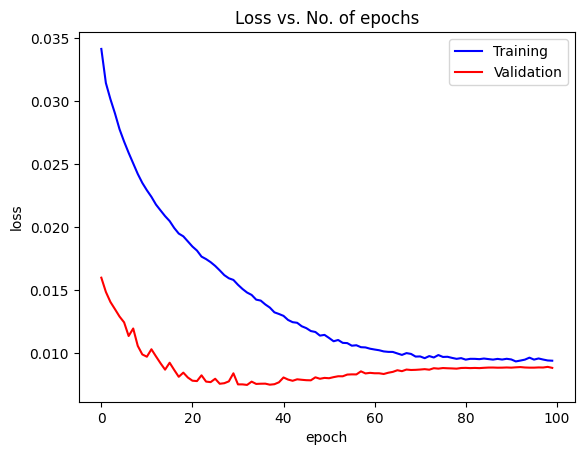

In [30]:
plot_loss(history2['train_loss'], history2['val_loss'])

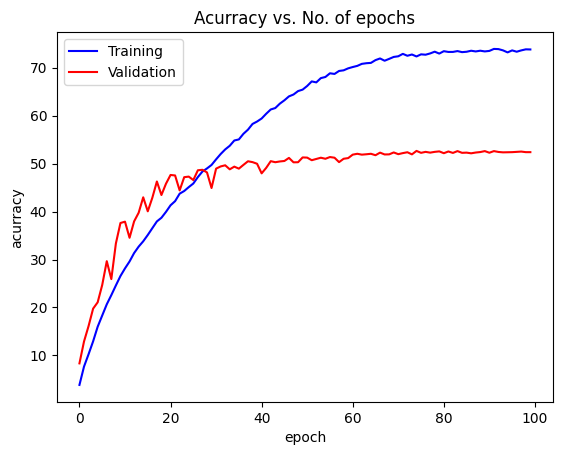

In [31]:
plot_acc(history2['train_acc'], history2['val_acc'])

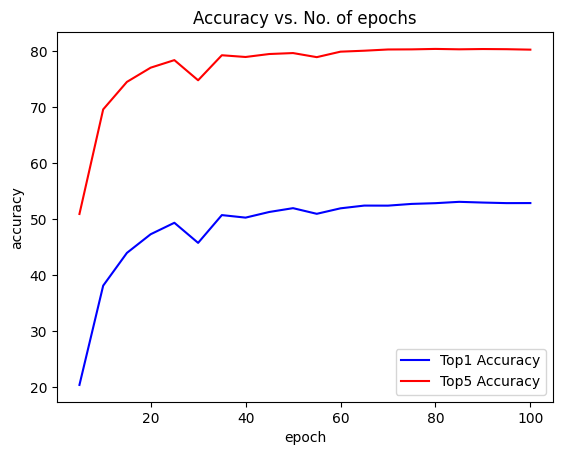

In [32]:
plot_test(history2['test_acc1'], history2['test_acc5'])

In [33]:
time_taken2 = np.array(history2['time'])
print("Average time per epoch for Wide_AAResNet =", np.mean(time_taken2))

Average time per epoch for Wide_AAResNet = 11.84288327217102


In [34]:
with open('wide_aaresnet_history_cifar', 'wb') as f:
  pickle.dump(history2, f)

# Defining The Model

In [35]:
from AA_CNN import LinearAttentionConv2d

In [36]:
class Wide_LAAResNet(nn.Module):
    def __init__(self, width = 4, dropout = 0.33, num_classes=100):
        super().__init__()
        self.Nh = 1
        self.dv = 8

        self.block0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.block11 = nn.Sequential(
            nn.Conv2d(16, 16*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 16*width,
                output_dim = 16*width,
                dk = 4*self.dv*width,
                dv = self.dv*width,
                num_heads = self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=16,
                width=16,
            ),
        )
        self.shortcut1 = nn.Conv2d(16, 16*width, kernel_size=1, stride=2)
        self.block12 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 16*width,
                output_dim = 16*width,
                dk = 4*self.dv*width,
                dv = self.dv*width,
                num_heads = self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=16,
                width=16,
            ),
        )


        self.pre_block2 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
        )
        self.block21 = nn.Sequential(
            nn.Conv2d(16*width, 32*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 32*width,
                output_dim = 32*width,
                dk = 8*self.dv*width,
                dv = 2*self.dv*width,
                num_heads = 2*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=8,
                width=8,
            ),
        )
        self.shortcut2 = nn.Conv2d(16*width, 32*width, kernel_size=1, stride=2)
        self.block22 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 32*width,
                output_dim = 32*width,
                dk = 8*self.dv*width,
                dv = 2*self.dv*width,
                num_heads = 2*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=8,
                width=8,
            ),
        )

        self.pre_block3 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
        )
        self.block31 = nn.Sequential(
            nn.Conv2d(32*width, 64*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 64*width,
                output_dim = 64*width,
                dk = 16*self.dv*width,
                dv = 4*self.dv*width,
                num_heads = 4*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=4,
                width=4,
            ),
        )
        self.shortcut3 = nn.Conv2d(32*width, 64*width, kernel_size=1, stride=2)
        self.block32 = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 64*width,
                output_dim = 64*width,
                dk = 16*self.dv*width,
                dv = 4*self.dv*width,
                num_heads = 4*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=4,
                width=4,
            ),
        )

        self.pool_block = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.AvgPool2d(4, 4),
        )

        self.fc = nn.Sequential(
            nn.Linear(64*width, 64*width),
            nn.ReLU(),
            nn.Dropout1d(dropout/2),
            nn.Linear(64*width, num_classes)
        )

    def forward(self, x):
        # x.shape = B x 3 x 32 x 32

        x = self.block0(x)
        # x.shape = B x 16 x 32 x 32

        x1 = self.block11(x)
        x2 = self.shortcut1(x)
        x3 = x1 + x2
        x4 = self.block12(x3)
        x = x4 + x3
        # x.shape = B x 16*width x 16 x 16

        x = self.pre_block2(x)
        x1 = self.block21(x)
        x2 = self.shortcut2(x)
        x3 = x1 + x2
        x4 = self.block22(x3)
        x = x4 + x3
        # x.shape = B x 32*width x 8 x 8

        x = self.pre_block3(x)
        x1 = self.block31(x)
        x2 = self.shortcut3(x)
        x3 = x1 + x2
        x4 = self.block32(x3)
        x = x4 + x3
        # x.shape = B x 64*width x 4 x 4

        x = self.pool_block(x)
        # x.shape = B x 64*width x 1 x 1

        x = torch.flatten(x, start_dim=1)
        # flatten all dimensions except batch (0th dim)
        # x.shape = B x 64*width

        x = self.fc(x)
        # x.shape = B x num_classes

        return x

# Training The Model

In [37]:
model3 = Wide_LAAResNet(width=8, dropout=0.5).to(device)
summary(model3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]          18,560
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          73,792
            Conv2d-9          [-1, 576, 16, 16]          74,304
          Softmax-10          [-1, 1, 256, 256]               0
          Softmax-11          [-1, 1, 256, 256]               0
           Conv2d-12           [-1, 64, 16, 16]           4,160
LinearAttentionConv2d-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 

In [38]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

optimizer = torch.optim.SGD
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
loss_fn = F.cross_entropy

history3 = train(model3, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=100)

  1%|          | 1/100 [00:13<21:50, 13.24s/it]

Epoch 1 -	Training Loss : 0.034111004251903956 	Validation Loss : 0.016217080640792848


  2%|▏         | 2/100 [00:26<21:32, 13.19s/it]

Epoch 2 -	Training Loss : 0.0314492063416375 	Validation Loss : 0.014855755710601807


  3%|▎         | 3/100 [00:39<21:20, 13.20s/it]

Epoch 3 -	Training Loss : 0.03028910936779446 	Validation Loss : 0.014164253664016723


  4%|▍         | 4/100 [00:52<21:04, 13.17s/it]

Epoch 4 -	Training Loss : 0.029250139866934883 	Validation Loss : 0.013380627059936524
Epoch 5 -	Training Loss : 0.0281834867477417 	Validation Loss : 0.012955262994766235


  5%|▌         | 5/100 [01:06<21:20, 13.48s/it]

Training Accuracy = 14.82 	Validation Accuracy = 22.52 	Test Accuracy Top1 = 21.78 	Test Accuracy Top5 = 50.5


  6%|▌         | 6/100 [01:19<20:50, 13.31s/it]

Epoch 6 -	Training Loss : 0.027176888751983642 	Validation Loss : 0.012373189163208008


  7%|▋         | 7/100 [01:32<20:32, 13.25s/it]

Epoch 7 -	Training Loss : 0.026452580706278483 	Validation Loss : 0.011710879468917846


  8%|▊         | 8/100 [01:45<20:14, 13.20s/it]

Epoch 8 -	Training Loss : 0.025852895402908325 	Validation Loss : 0.011227248907089234


  9%|▉         | 9/100 [01:59<19:59, 13.19s/it]

Epoch 9 -	Training Loss : 0.02527923002243042 	Validation Loss : 0.011049434995651246
Epoch 10 -	Training Loss : 0.02469685147073534 	Validation Loss : 0.010625069284439088


 10%|█         | 10/100 [02:13<20:15, 13.50s/it]

Training Accuracy = 23.357777777777777 	Validation Accuracy = 33.7 	Test Accuracy Top1 = 34.05 	Test Accuracy Top5 = 65.33


 11%|█         | 11/100 [02:26<19:53, 13.41s/it]

Epoch 11 -	Training Loss : 0.02419891462855869 	Validation Loss : 0.010375237560272216


 12%|█▏        | 12/100 [02:39<19:36, 13.37s/it]

Epoch 12 -	Training Loss : 0.023745747656292386 	Validation Loss : 0.010205409240722656


 13%|█▎        | 13/100 [02:53<19:20, 13.34s/it]

Epoch 13 -	Training Loss : 0.023150181690851847 	Validation Loss : 0.011433623790740966


 14%|█▍        | 14/100 [03:06<19:03, 13.30s/it]

Epoch 14 -	Training Loss : 0.02298093130853441 	Validation Loss : 0.009859398174285888
Epoch 15 -	Training Loss : 0.022419374826219345 	Validation Loss : 0.009715865659713744


 15%|█▌        | 15/100 [03:20<19:17, 13.62s/it]

Training Accuracy = 29.702222222222222 	Validation Accuracy = 37.86 	Test Accuracy Top1 = 38.17 	Test Accuracy Top5 = 70.28


 16%|█▌        | 16/100 [03:33<18:53, 13.49s/it]

Epoch 16 -	Training Loss : 0.02206423888736301 	Validation Loss : 0.009161404657363892


 17%|█▋        | 17/100 [03:47<18:32, 13.41s/it]

Epoch 17 -	Training Loss : 0.02161024317741394 	Validation Loss : 0.009461263132095337


 18%|█▊        | 18/100 [04:00<18:14, 13.34s/it]

Epoch 18 -	Training Loss : 0.021276512744691636 	Validation Loss : 0.0088471923828125


 19%|█▉        | 19/100 [04:13<18:00, 13.34s/it]

Epoch 19 -	Training Loss : 0.020842732916937935 	Validation Loss : 0.008934043455123901
Epoch 20 -	Training Loss : 0.020488942872153387 	Validation Loss : 0.00895977792739868


 20%|██        | 20/100 [04:27<18:04, 13.56s/it]

Training Accuracy = 35.21111111111111 	Validation Accuracy = 41.24 	Test Accuracy Top1 = 42.61 	Test Accuracy Top5 = 73.91


 21%|██        | 21/100 [04:40<17:44, 13.48s/it]

Epoch 21 -	Training Loss : 0.020178891817728677 	Validation Loss : 0.0085697988986969


 22%|██▏       | 22/100 [04:54<17:27, 13.43s/it]

Epoch 22 -	Training Loss : 0.01974970088005066 	Validation Loss : 0.009310834074020386


 23%|██▎       | 23/100 [05:07<17:09, 13.38s/it]

Epoch 23 -	Training Loss : 0.019567121532228258 	Validation Loss : 0.008511582207679749


 24%|██▍       | 24/100 [05:20<16:50, 13.30s/it]

Epoch 24 -	Training Loss : 0.01925582430627611 	Validation Loss : 0.00790510241985321
Epoch 25 -	Training Loss : 0.01892711574766371 	Validation Loss : 0.007713865065574646


 25%|██▌       | 25/100 [05:34<16:56, 13.56s/it]

Training Accuracy = 39.522222222222226 	Validation Accuracy = 48.7 	Test Accuracy Top1 = 48.71 	Test Accuracy Top5 = 79.41


 26%|██▌       | 26/100 [05:48<16:39, 13.51s/it]

Epoch 26 -	Training Loss : 0.01874718028439416 	Validation Loss : 0.007819474816322327


 27%|██▋       | 27/100 [06:01<16:21, 13.45s/it]

Epoch 27 -	Training Loss : 0.018372328154246012 	Validation Loss : 0.007707919430732727


 28%|██▊       | 28/100 [06:14<16:06, 13.42s/it]

Epoch 28 -	Training Loss : 0.018207528278562757 	Validation Loss : 0.007450449633598328


 29%|██▉       | 29/100 [06:28<15:49, 13.38s/it]

Epoch 29 -	Training Loss : 0.017827796244621278 	Validation Loss : 0.008811940193176269
Epoch 30 -	Training Loss : 0.017665476727485658 	Validation Loss : 0.007405941104888916


 30%|███       | 30/100 [06:42<15:52, 13.60s/it]

Training Accuracy = 43.437777777777775 	Validation Accuracy = 49.42 	Test Accuracy Top1 = 50.81 	Test Accuracy Top5 = 80.15


 31%|███       | 31/100 [06:55<15:28, 13.46s/it]

Epoch 31 -	Training Loss : 0.017419605006111994 	Validation Loss : 0.0073199581146240235


 32%|███▏      | 32/100 [07:08<15:10, 13.38s/it]

Epoch 32 -	Training Loss : 0.017259881954722934 	Validation Loss : 0.007451652359962463


 33%|███▎      | 33/100 [07:21<14:52, 13.32s/it]

Epoch 33 -	Training Loss : 0.016864570599132114 	Validation Loss : 0.007068624687194824


 34%|███▍      | 34/100 [07:35<14:38, 13.31s/it]

Epoch 34 -	Training Loss : 0.016733224754863316 	Validation Loss : 0.007181875658035278
Epoch 35 -	Training Loss : 0.016352381388346354 	Validation Loss : 0.007102592849731445


 35%|███▌      | 35/100 [07:49<14:43, 13.59s/it]

Training Accuracy = 47.66 	Validation Accuracy = 51.54 	Test Accuracy Top1 = 51.88 	Test Accuracy Top5 = 81.32


 36%|███▌      | 36/100 [08:02<14:22, 13.47s/it]

Epoch 36 -	Training Loss : 0.016175463019476997 	Validation Loss : 0.007109460353851319


 37%|███▋      | 37/100 [08:15<14:03, 13.40s/it]

Epoch 37 -	Training Loss : 0.015888541926278008 	Validation Loss : 0.007037487602233887


 38%|███▊      | 38/100 [08:29<13:49, 13.37s/it]

Epoch 38 -	Training Loss : 0.01571875261200799 	Validation Loss : 0.007178754806518555


 39%|███▉      | 39/100 [08:42<13:35, 13.37s/it]

Epoch 39 -	Training Loss : 0.015526040058665806 	Validation Loss : 0.0069321988582611085
Epoch 40 -	Training Loss : 0.01520199179649353 	Validation Loss : 0.006999027967453003


 40%|████      | 40/100 [08:56<13:37, 13.63s/it]

Training Accuracy = 51.184444444444445 	Validation Accuracy = 51.78 	Test Accuracy Top1 = 52.74 	Test Accuracy Top5 = 82.14


 41%|████      | 41/100 [09:09<13:17, 13.52s/it]

Epoch 41 -	Training Loss : 0.01501187813282013 	Validation Loss : 0.006988472056388855


 42%|████▏     | 42/100 [09:23<12:59, 13.44s/it]

Epoch 42 -	Training Loss : 0.014902978256013659 	Validation Loss : 0.006972578310966491


 43%|████▎     | 43/100 [09:36<12:38, 13.30s/it]

Epoch 43 -	Training Loss : 0.014713514465755886 	Validation Loss : 0.0073765385389328005


 44%|████▍     | 44/100 [09:49<12:25, 13.31s/it]

Epoch 44 -	Training Loss : 0.014441234707832337 	Validation Loss : 0.006999240756034851
Epoch 45 -	Training Loss : 0.014231185081270007 	Validation Loss : 0.008320610952377318


 45%|████▌     | 45/100 [10:03<12:27, 13.59s/it]

Training Accuracy = 54.88444444444445 	Validation Accuracy = 46.22 	Test Accuracy Top1 = 47.23 	Test Accuracy Top5 = 76.7


 46%|████▌     | 46/100 [10:16<12:08, 13.49s/it]

Epoch 46 -	Training Loss : 0.01409299307399326 	Validation Loss : 0.006909477210044861


 47%|████▋     | 47/100 [10:30<11:49, 13.39s/it]

Epoch 47 -	Training Loss : 0.013922323830922444 	Validation Loss : 0.0070499239444732666


 48%|████▊     | 48/100 [10:43<11:34, 13.36s/it]

Epoch 48 -	Training Loss : 0.013609950460327995 	Validation Loss : 0.006879323124885559


 49%|████▉     | 49/100 [10:56<11:22, 13.39s/it]

Epoch 49 -	Training Loss : 0.013498903200361463 	Validation Loss : 0.008386340951919556
Epoch 50 -	Training Loss : 0.01322064847946167 	Validation Loss : 0.006930053734779358


 50%|█████     | 50/100 [11:10<11:17, 13.56s/it]

Training Accuracy = 58.37555555555556 	Validation Accuracy = 52.78 	Test Accuracy Top1 = 54.25 	Test Accuracy Top5 = 82.85


 51%|█████     | 51/100 [11:23<10:55, 13.37s/it]

Epoch 51 -	Training Loss : 0.013162382099363538 	Validation Loss : 0.006951927495002746


 52%|█████▏    | 52/100 [11:36<10:35, 13.24s/it]

Epoch 52 -	Training Loss : 0.013070701514350044 	Validation Loss : 0.006941203594207764


 53%|█████▎    | 53/100 [11:49<10:16, 13.12s/it]

Epoch 53 -	Training Loss : 0.01277491164472368 	Validation Loss : 0.007001538109779358


 54%|█████▍    | 54/100 [12:02<10:01, 13.07s/it]

Epoch 54 -	Training Loss : 0.01267774526807997 	Validation Loss : 0.006907664012908935
Epoch 55 -	Training Loss : 0.012445479718844096 	Validation Loss : 0.006894225573539734


 55%|█████▌    | 55/100 [12:16<09:57, 13.28s/it]

Training Accuracy = 61.37111111111111 	Validation Accuracy = 53.78 	Test Accuracy Top1 = 54.56 	Test Accuracy Top5 = 82.97


 56%|█████▌    | 56/100 [12:29<09:39, 13.16s/it]

Epoch 56 -	Training Loss : 0.012297873944706387 	Validation Loss : 0.006993128514289856


 57%|█████▋    | 57/100 [12:41<09:22, 13.08s/it]

Epoch 57 -	Training Loss : 0.01235356800556183 	Validation Loss : 0.007049041509628296


 58%|█████▊    | 58/100 [12:54<09:07, 13.02s/it]

Epoch 58 -	Training Loss : 0.0120746667848693 	Validation Loss : 0.007167835259437561


 59%|█████▉    | 59/100 [13:07<08:52, 12.99s/it]

Epoch 59 -	Training Loss : 0.011931005350748697 	Validation Loss : 0.007166725301742553
Epoch 60 -	Training Loss : 0.011847187023692661 	Validation Loss : 0.007173425221443176


 60%|██████    | 60/100 [13:21<08:49, 13.24s/it]

Training Accuracy = 63.73777777777778 	Validation Accuracy = 53.5 	Test Accuracy Top1 = 54.39 	Test Accuracy Top5 = 82.69


 61%|██████    | 61/100 [13:34<08:31, 13.13s/it]

Epoch 61 -	Training Loss : 0.011695093862215677 	Validation Loss : 0.007025233006477356


 62%|██████▏   | 62/100 [13:47<08:16, 13.05s/it]

Epoch 62 -	Training Loss : 0.01163588191403283 	Validation Loss : 0.007155204129219055


 63%|██████▎   | 63/100 [14:00<08:01, 13.01s/it]

Epoch 63 -	Training Loss : 0.011444520972834693 	Validation Loss : 0.007130141496658325


 64%|██████▍   | 64/100 [14:13<07:49, 13.05s/it]

Epoch 64 -	Training Loss : 0.011366034826967452 	Validation Loss : 0.007271007800102234
Epoch 65 -	Training Loss : 0.011163232860300276 	Validation Loss : 0.007203975081443786


 65%|██████▌   | 65/100 [14:27<07:47, 13.35s/it]

Training Accuracy = 66.32222222222222 	Validation Accuracy = 54.24 	Test Accuracy Top1 = 54.82 	Test Accuracy Top5 = 82.57


 66%|██████▌   | 66/100 [14:40<07:28, 13.20s/it]

Epoch 66 -	Training Loss : 0.011162097826268938 	Validation Loss : 0.007197683548927307


 67%|██████▋   | 67/100 [14:53<07:11, 13.08s/it]

Epoch 67 -	Training Loss : 0.011014016012350717 	Validation Loss : 0.007212175297737122


 68%|██████▊   | 68/100 [15:05<06:56, 13.01s/it]

Epoch 68 -	Training Loss : 0.010992848983075884 	Validation Loss : 0.007267298150062561


 69%|██████▉   | 69/100 [15:18<06:41, 12.95s/it]

Epoch 69 -	Training Loss : 0.010841674770249261 	Validation Loss : 0.007361808466911316
Epoch 70 -	Training Loss : 0.010723962977197436 	Validation Loss : 0.007350821805000306


 70%|███████   | 70/100 [15:32<06:34, 13.16s/it]

Training Accuracy = 68.16 	Validation Accuracy = 54.18 	Test Accuracy Top1 = 54.71 	Test Accuracy Top5 = 82.64


 71%|███████   | 71/100 [15:45<06:17, 13.03s/it]

Epoch 71 -	Training Loss : 0.010773843563927545 	Validation Loss : 0.0073315144777297975


 72%|███████▏  | 72/100 [15:58<06:03, 12.98s/it]

Epoch 72 -	Training Loss : 0.010633809906906553 	Validation Loss : 0.007637463259696961


 73%|███████▎  | 73/100 [16:10<05:48, 12.90s/it]

Epoch 73 -	Training Loss : 0.010618254392676883 	Validation Loss : 0.00735921528339386


 74%|███████▍  | 74/100 [16:23<05:34, 12.87s/it]

Epoch 74 -	Training Loss : 0.010506185229619344 	Validation Loss : 0.007366307640075683
Epoch 75 -	Training Loss : 0.010701822805404663 	Validation Loss : 0.007458729791641235


 75%|███████▌  | 75/100 [16:37<05:28, 13.15s/it]

Training Accuracy = 68.7311111111111 	Validation Accuracy = 54.26 	Test Accuracy Top1 = 54.64 	Test Accuracy Top5 = 82.44


 76%|███████▌  | 76/100 [16:50<05:13, 13.06s/it]

Epoch 76 -	Training Loss : 0.010566382025347815 	Validation Loss : 0.007446646404266358


 77%|███████▋  | 77/100 [17:02<04:58, 12.98s/it]

Epoch 77 -	Training Loss : 0.010440773420863681 	Validation Loss : 0.007414135909080505


 78%|███████▊  | 78/100 [17:15<04:44, 12.94s/it]

Epoch 78 -	Training Loss : 0.010341264096895854 	Validation Loss : 0.007427688384056092


 79%|███████▉  | 79/100 [17:28<04:30, 12.90s/it]

Epoch 79 -	Training Loss : 0.0103042193836636 	Validation Loss : 0.007433327198028564
Epoch 80 -	Training Loss : 0.010346714025073582 	Validation Loss : 0.007493189787864685


 80%|████████  | 80/100 [17:42<04:24, 13.24s/it]

Training Accuracy = 70.0911111111111 	Validation Accuracy = 54.0 	Test Accuracy Top1 = 54.87 	Test Accuracy Top5 = 83.01


 81%|████████  | 81/100 [17:55<04:09, 13.14s/it]

Epoch 81 -	Training Loss : 0.010416268666585286 	Validation Loss : 0.007509195971488952


 82%|████████▏ | 82/100 [18:08<03:54, 13.05s/it]

Epoch 82 -	Training Loss : 0.010318099068270789 	Validation Loss : 0.007535606217384338


 83%|████████▎ | 83/100 [18:21<03:40, 12.97s/it]

Epoch 83 -	Training Loss : 0.010255528779824575 	Validation Loss : 0.007518382668495178


 84%|████████▍ | 84/100 [18:34<03:27, 12.95s/it]

Epoch 84 -	Training Loss : 0.010161614025963677 	Validation Loss : 0.007510072922706604
Epoch 85 -	Training Loss : 0.010249138797654047 	Validation Loss : 0.007563038516044617


 85%|████████▌ | 85/100 [18:48<03:18, 13.26s/it]

Training Accuracy = 70.52666666666667 	Validation Accuracy = 54.24 	Test Accuracy Top1 = 54.99 	Test Accuracy Top5 = 82.79


 86%|████████▌ | 86/100 [19:01<03:04, 13.20s/it]

Epoch 86 -	Training Loss : 0.010165712704923419 	Validation Loss : 0.0075380050659179685


 87%|████████▋ | 87/100 [19:14<02:51, 13.19s/it]

Epoch 87 -	Training Loss : 0.010129115666283502 	Validation Loss : 0.0075205978631973265


 88%|████████▊ | 88/100 [19:27<02:37, 13.14s/it]

Epoch 88 -	Training Loss : 0.01014977145459917 	Validation Loss : 0.0075507691144943235


 89%|████████▉ | 89/100 [19:40<02:23, 13.09s/it]

Epoch 89 -	Training Loss : 0.010245135672887167 	Validation Loss : 0.007543574619293213
Epoch 90 -	Training Loss : 0.01013099827501509 	Validation Loss : 0.007542495942115784


 90%|█████████ | 90/100 [19:54<02:13, 13.40s/it]

Training Accuracy = 70.94 	Validation Accuracy = 54.24 	Test Accuracy Top1 = 55.12 	Test Accuracy Top5 = 82.84


 91%|█████████ | 91/100 [20:07<01:59, 13.25s/it]

Epoch 91 -	Training Loss : 0.010080195926295386 	Validation Loss : 0.007543770241737365


 92%|█████████▏| 92/100 [20:20<01:46, 13.25s/it]

Epoch 92 -	Training Loss : 0.010126126935746934 	Validation Loss : 0.007555393290519715


 93%|█████████▎| 93/100 [20:33<01:32, 13.17s/it]

Epoch 93 -	Training Loss : 0.01008290189107259 	Validation Loss : 0.007543726181983948


 94%|█████████▍| 94/100 [20:46<01:18, 13.16s/it]

Epoch 94 -	Training Loss : 0.010126781780189938 	Validation Loss : 0.007569151949882507
Epoch 95 -	Training Loss : 0.009991200764973958 	Validation Loss : 0.007549461507797241


 95%|█████████▌| 95/100 [21:01<01:07, 13.54s/it]

Training Accuracy = 71.63111111111111 	Validation Accuracy = 54.46 	Test Accuracy Top1 = 55.41 	Test Accuracy Top5 = 83.01


 96%|█████████▌| 96/100 [21:14<00:53, 13.47s/it]

Epoch 96 -	Training Loss : 0.010059666971365611 	Validation Loss : 0.007551802468299866


 97%|█████████▋| 97/100 [21:27<00:40, 13.47s/it]

Epoch 97 -	Training Loss : 0.010088985448413424 	Validation Loss : 0.007534152317047119


 98%|█████████▊| 98/100 [21:41<00:26, 13.46s/it]

Epoch 98 -	Training Loss : 0.010187597419155968 	Validation Loss : 0.007547552323341369


 99%|█████████▉| 99/100 [21:54<00:13, 13.38s/it]

Epoch 99 -	Training Loss : 0.010189709436893462 	Validation Loss : 0.007560835599899292
Epoch 100 -	Training Loss : 0.010056406491332584 	Validation Loss : 0.007530298590660095


100%|██████████| 100/100 [22:08<00:00, 13.29s/it]

Training Accuracy = 71.30444444444444 	Validation Accuracy = 54.64 	Test Accuracy Top1 = 55.32 	Test Accuracy Top5 = 82.95


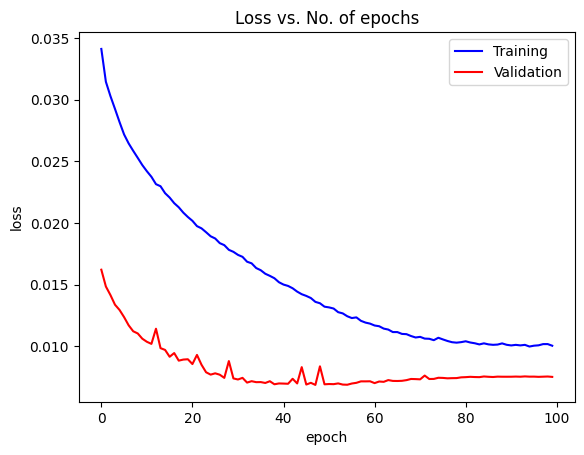

In [39]:
plot_loss(history3['train_loss'], history3['val_loss'])

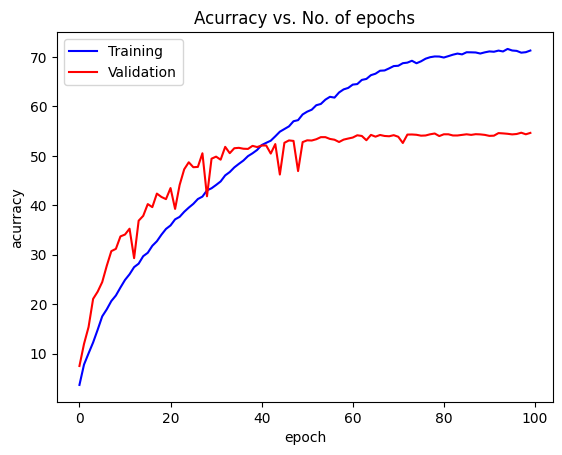

In [40]:
plot_acc(history3['train_acc'], history3['val_acc'])

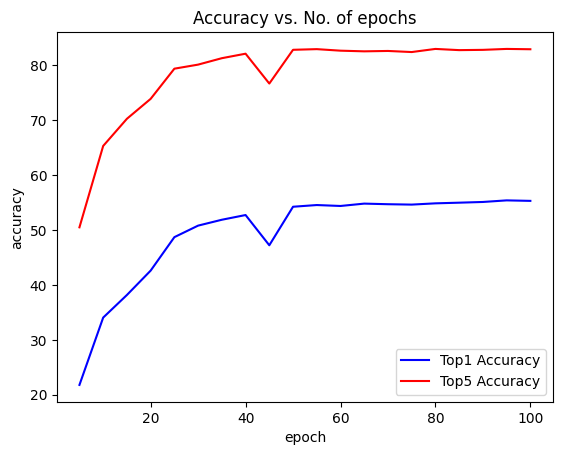

In [41]:
plot_test(history3['test_acc1'], history3['test_acc5'])

In [42]:
time_taken3 = np.array(history3['time'])
print("Average time per epoch for Wide_LAAResNet =", np.mean(time_taken3))

Average time per epoch for Wide_LAAResNet = 12.614249691963195


In [43]:
with open('wide_laaresnet_history_cifar', 'wb') as f:
  pickle.dump(history3, f)